In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        # - "04_11_24_WBC_UniverSeg_CalibrationAblation"
        - "04_11_24_SpineWeb_UniverSeg_CalibrationAblation"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 180 -> 180 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                                              log_set                                              
/storage/vbutoi/scratch/ESE/inference/04_11_24_SpineWeb_UniverSeg_CalibrationAblation/SpineWeb_Ensemble_Uncalibrated  20240411_114317-0GCF-f5f1507461c5559a573bbd709a566cef    195
dtype: int64


In [4]:
image_info_df['calibrator'].unique()

array(['Uncalibrated'], dtype=object)

In [5]:
# Sort the image_info_df by method name, so everything appears nicely
image_info_df = image_info_df.sort_values(by=['method_name', 'calibrator'])
# Make sure that the model_class 'Uncalibrated' is first
image_info_df['calibrator'] = image_info_df['calibrator'].astype('category')
image_info_df['calibrator'] = image_info_df['calibrator'].cat.reorder_categories([
    'Uncalibrated',
])

In [6]:
image_info_df.keys()

Index(['support_idx', 'data_id', 'split', 'slice_idx', 'image_metric',
       'metric_score', 'groupavg_image_metric', 'groupavg_metric_score',
       'num_lab_0_pixels', 'num_lab_1_pixels', 'ECE', 'Edge-ECE', 'CW-ECE',
       'ECW-ECE', 'Uniform-CW-ECE', 'Uniform-ECW-ECE', 'log_set',
       'calibrator._class', 'calibrator._name', 'calibrator.normalize',
       'data.input_type', 'data.label', 'data.preload', 'data.resolution',
       'data.slicing', 'data.splits', 'data.support_size', 'data.task',
       'dataloader.batch_size', 'dataloader.num_workers',
       'dataloader.pin_memory', 'dataset._class', 'dataset.label',
       'dataset.min_label_density', 'dataset.preload', 'dataset.resolution',
       'dataset.return_data_id', 'dataset.samples_per_epoch',
       'dataset.slicing', 'dataset.support_size', 'dataset.task',
       'dataset.version', 'ensemble.combine_fn', 'ensemble.combine_quantity',
       'ensemble.normalize', 'ensemble.num_members', 'experiment.dataset_name',
       

In [7]:
image_info_df['image_metric'].unique()

array(['Dice', 'HD95', 'BoundaryIOU', 'Pixel-Ambiguity',
       'Soft-Region-Ambiguity', 'Hard-Region-Ambiguity', 'Image_ECE',
       'Image_Edge-ECE', 'Image_CW-ECE', 'Image_ECW-ECE',
       'Image_Uniform-CW-ECE', 'Image_Uniform-ECW-ECE', 'Dice Loss'],
      dtype=object)

In [8]:
# Sort the df by the data_id
image_info_df = image_info_df.sort_values(by=['data_id'])

Text(0.5, 1.0, 'SpineWeb Dice Loss per Datapoint')

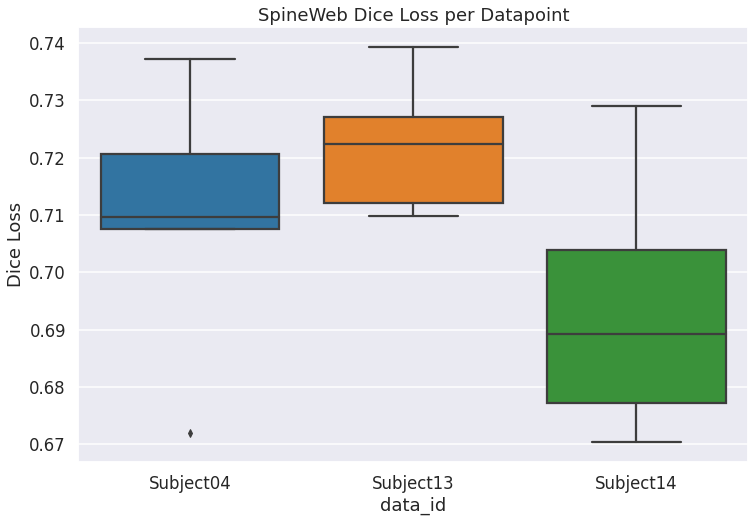

In [12]:
dice_info_df = image_info_df[image_info_df['image_metric'] == 'Dice Loss']

plt.figure(figsize=(12, 8))
sns.boxplot(
    x='data_id', 
    y='metric_score', 
    data=dice_info_df
)
plt.ylabel('Dice Loss')
plt.title('SpineWeb Dice Loss per Datapoint')

Text(0.5, 1.0, 'SpineWeb Image ECE per Datapoint')

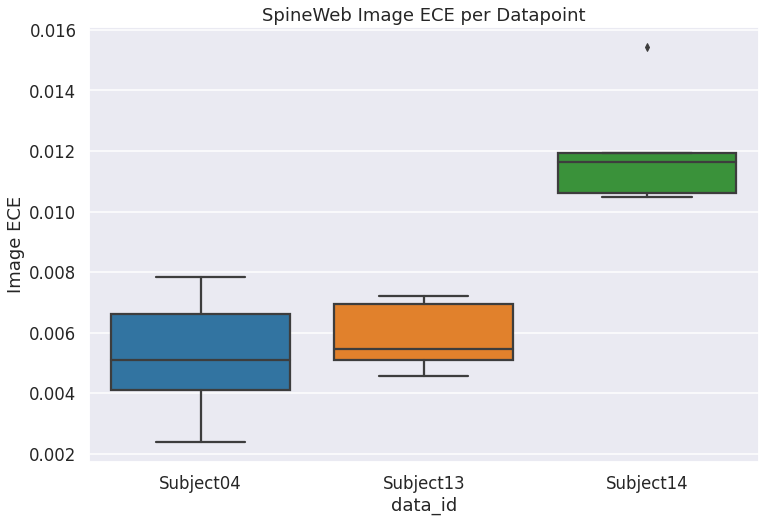

In [11]:
ece_info_df = image_info_df[image_info_df['image_metric'] == 'Image_ECE']

plt.figure(figsize=(12, 8))
sns.boxplot(
    x='data_id', 
    y='metric_score', 
    data=ece_info_df
)
# Set the y label to be Image ECE
plt.ylabel('Image ECE')
plt.title('SpineWeb Image ECE per Datapoint')